In [2]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import scipy.optimize as sco
import matplotlib.pyplot as plt
import datetime
from pandas import Series, DataFrame

### 匯入價格資料

In [3]:
Data = pd.read_excel("myAssetPool_final.xlsx", sheet_name = 'Adj_close', index_col=0)
Data.head()

,JKE,IWF,VTI,AOA,SCHX,VPL,VWO,BND,AGG,BLV,IAU
Date,,,,,,,,,,,
2013-12-31,94.472626,79.201256,84.738609,37.710819,39.011066,51.982285,34.600319,67.142357,90.489296,63.431301,11.68
2014-01-02,93.923103,78.510162,83.996521,37.321964,38.665913,51.057976,33.389236,67.201050,90.548790,63.648823,11.88
2014-01-03,93.496719,78.408775,83.978867,37.347317,38.674755,51.244526,33.347179,67.209480,90.582863,63.765339,12.01
2014-01-06,93.250404,77.938866,83.757996,37.296593,38.577400,51.032539,33.027584,67.268166,90.701874,63.920723,12.01
2014-01-07,93.913635,78.547020,84.296883,37.465664,38.816353,51.185162,33.162144,67.352066,90.744354,64.130486,11.95


### 計算投資組合報酬率、標準差及Sharpe Ratio

In [4]:
ret = Data.pct_change() # daily return in percentage
cov = ret.cov()* 252

w = np.random.random(len(Data.columns))
w/= np.sum(w)

def port_data(ret, cov, weights):
    port_ret = np.sum(ret.mean()* weights) * 252
    port_var = np.dot(weights.T, np.dot(cov * 252, weights))
    port_std = np.sqrt(port_var)
    port_sharpe = port_ret / port_var
    
    return port_ret, port_std, port_sharpe

In [5]:
sum_sta = port_data(ret, cov, w)
sum_sta

(0.0690418766891574, 1.2924727240435343, 0.041330419612027616)

### 求最大Sharpe Ratio及最小波動率投資組合

In [6]:
def statistics(weights):
    weights = np.array(weights)
    port_ret = np.sum(ret.mean()*weights) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(ret.cov()*252,weights)))
    
    return np.array([port_ret, port_vol, port_ret/port_vol])

def min_sharpe(weights):
    return -statistics(weights)[2]

def min_var(weights):
    return statistics(weights)[1]

num_assets = len(Data.columns)
bounds = tuple((0,1) for x in range(num_assets))
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
opt_sharpe = sco.minimize(min_sharpe, num_assets* [1./num_assets,], method= 'SLSQP', bounds = bounds, constraints = cons)
opt_vol = sco.minimize(min_var, num_assets* [1./num_assets,], method= 'SLSQP', bounds = bounds, constraints = cons)


In [7]:
opt_sharpe

     fun: -1.5553057259806577
     jac: array([ 1.33529305e-04, -4.98920679e-04,  1.55251190e-01,  7.68965289e-01,
        3.80203277e-02,  1.80919346e+00,  2.77824698e+00,  1.04337931e-04,
        4.11112607e-03,  3.55283961e-01,  7.10149303e-01])
 message: 'Optimization terminated successfully'
    nfev: 169
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([1.05741334e-03, 1.72963700e-01, 1.70653422e-15, 0.00000000e+00,
       1.83490376e-15, 0.00000000e+00, 0.00000000e+00, 8.25978887e-01,
       6.35199358e-14, 0.00000000e+00, 0.00000000e+00])

In [8]:
opt_vol

     fun: 0.026961500988042144
     jac: array([0.03428045, 0.03391027, 0.02763461, 0.02742936, 0.02765845,
       0.03135991, 0.04575731, 0.02681592, 0.02697069, 0.06846329,
       0.04268529])
 message: 'Optimization terminated successfully'
    nfev: 144
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.00000000e+00, 2.08153248e-17, 3.94092355e-02, 1.25466865e-02,
       4.33424358e-02, 0.00000000e+00, 1.58661307e-18, 4.58191055e-01,
       4.46510587e-01, 8.89660466e-17, 0.00000000e+00])

In [9]:
target_returns = np.linspace(0.02, 0.08, 50)
target_vol = []

cnt = 0
for tar in target_returns:
    cons = ({'type':'eq','fun':lambda x:statistics(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res = sco.minimize(min_var, num_assets*[1./num_assets,],method = 'SLSQP', bounds = bounds, constraints = cons)
    target_vol.append(res['fun'])
    cnt += 1
    print(cnt)

target_vol = np.array(target_vol)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


### 繪製效率前緣圖

Max_Sharpe:  0.04865762940596025 0.03128492912560998 1.5553057259806577
Min_Volatility:  0.0369948242145382 0.026961500988042144 1.3721351875381862


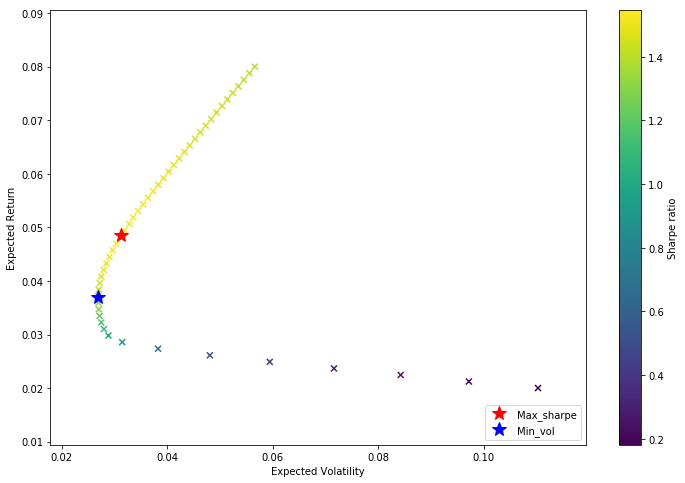

In [11]:
plt.figure(figsize=(12, 8))
plt.scatter(target_vol,target_returns, c = target_returns/target_vol, marker = 'x')
plt.plot(statistics(opt_sharpe['x'])[1],statistics(opt_sharpe['x'])[0],'r*', markersize=15.0, label='Max_sharpe')
plt.plot(statistics(opt_vol['x'])[1],statistics(opt_vol['x'])[0],'b*', markersize=15.0, label='Min_vol')

#plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label = 'Sharpe ratio')
plt.legend(loc = 'lower right')
print('Max_Sharpe: ', statistics(opt_sharpe['x'])[0], statistics(opt_sharpe['x'])[1], statistics(opt_sharpe['x'])[2])
print('Min_Volatility: ', statistics(opt_vol['x'])[0], statistics(opt_vol['x'])[1], statistics(opt_vol['x'])[2])
